# Single-cell Genomics

[Single-cell RNA sequencing](https://en.wikipedia.org/wiki/Single_cell_sequencing) (scRNA-seq) is a technology that provides the [gene expression profile](https://en.wikipedia.org/wiki/Gene_expression_profiling) of a single-cell. scRNA-seq can help describe a cell as a vector of features, where each feature represents the expression level of a gene in that cell upon measurement. Given a large population of cells observed through time, one can sample a few of these cells at different points in time, and produce at each time point as many feature vectors through scRNA-seq, and obtain a point cloud. Each of these point clouds provide a clear picture of the diversity of cells at each point time. Taken together, they describe the collective evolution of these cells along a developmental time-course. However, as measuring destroys the cells, one cannot follow gene expression of the exact same cell through time. 

Optimal transport can help us infer individual trajectories from the dynamics of the population overall, and answer questions such as what are the descendants or ancestors of each cell.

In this notebook, we infer the ancestors of [induced pluripotent stem cells (iPSCs)](https://en.wikipedia.org/wiki/Induced_pluripotent_stem_cell) using temporal snapshots sampled twice or four times a day for a period of 18 days. iPSCs are a type of [pluripotent stem cells](https://en.wikipedia.org/wiki/Cell_potency#Pluripotency) that can be generated from specialized cells. Identifying the ancestors of iPSCs would enable us to know which specialized cells are able to revert to iPSCs. 

**Reference**

The optimal transport pipeline of this notebook has been adapted from {cite}`schiebinger:19`. The data was downloaded from the corresponding [WOT tutorial](https://broadinstitute.github.io/wot/tutorial/).

In [ ]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [ ]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

## Optimal transport on scRNA-seq data

The optimal transport between pairs of gene expression matrices, measured at consecutive time points, is calculated. As a preprocessing step, the cell profiles are projected to a 30-dimensional space with PCA, as suggested in {cite}`schiebinger:19`.

- `DAYS` is an array of measurement days from 0 to 18.
- `PCA30_SERUM_DAY` is a dictionary, which contains as keys the measurement days and as values the low-dimensional representation of gene expression matrices.
- `CELL_GROWTH_RATE` is a dictionary, which contains as keys the measurement days and as values the cell growth rate vectors.

The optimal transport is calculated between each consecutive pair of datasets.

In [2]:
# Defines the optimal transport regularisation parameter
solver = sinkhorn.Sinkhorn()
epsilon = 5

dict_results = {}
for i, day in enumerate(DAYS):
    if day == 18.0:
        continue
    print(
        "\r"
        + f"Executing Sinkhorn between the days {day} and {DAYS[i+1]} / 18",
        end="",
    )
    # Computes the marginals
    delta_days = DAYS[i + 1] - day
    n = PCA30_SERUM_DAY[DAYS[i + 1]].shape[0]
    # The original data has been transformed with PCA as described in `Schiebinger et al. (2019)`
    a = (
        np.power(CELL_GROWTH_RATE[day], delta_days)
        / np.mean(np.power(CELL_GROWTH_RATE[day], delta_days))
        / n
    )
    b = np.ones(n) / n

    # Applies optimal transport
    geom = pointcloud.PointCloud(
        PCA30_SERUM_DAY[day], PCA30_SERUM_DAY[DAYS[i + 1]], epsilon=epsilon
    )
    prob = linear_problem.LinearProblem(
        geom, a, b, tau_a=1.0 / (1.0 + epsilon), tau_b=1.0
    )
    dict_results[day] = solver(prob)

Executing Sinkhorn on pair of datasets for the days 17.5 and 18.0 / 18

## Infers cells' ancestors

Cells that are identified as induced pluripotent stem cells (iPSCs) at day 18  are selected, and its ancestors at each previous time points, from day 18 to day 0, are inferred. To do so, the method {meth}`~ott.geometry.pointcloud.PointCloud.apply_transport_from_potentials` is used, which enables to perform the pull back operation without instantiating directly the transport matrix. 

`CELL_DISTRIBUTION_IPSC_DAY18` is a normalized indicator array of cells identified as iPSCs at day 18.

In [3]:
cell_distribution_ipsc = {}
reverse_days = DAYS[::-1]
for i, day in enumerate(reverse_days):
    print("\r" + f"Infering ancestor cells at day {day}", end="")
    if day == 0.0:
        continue
    if day == 18.0:
        cell_distribution_ipsc[day] = CELL_DISTRIBUTION_IPSC_DAY18

    # Calculates cells' ancestors
    cell_distribution = dict_results[reverse_days[i + 1]].apply(
        cell_distribution_ipsc[day], axis=1
    )
    cell_distribution_ipsc[reverse_days[i + 1]] = cell_distribution / np.sum(
        cell_distribution
    )

Calculating ancestor cells at day 0.0

## Visualize

Once the ancestors of iPSCs are identified, they are represented on a low-dimensional space thanks to an FLE visualization. The iPSCs and its ancestors are colored while all the other cells remain in gray:

- `COORD_DF` is a data frame that contains the coordinates of all cells on the FLE visualization.
- `IDS_CELLS` is a dictionary that contains as keys the measurement days and as values the IDs of the cells.

All the cells can be represented in a 2D space thanks to an FLE visualization {cite}`schiebinger:19`. The cells' coordinates are binarized.  

In [4]:
nbins = 500
xrange = COORD_DF["x"].min(), COORD_DF["x"].max()
yrange = COORD_DF["y"].min(), COORD_DF["y"].max()
COORD_DF["x"] = np.floor(
    np.interp(COORD_DF["x"], [xrange[0], xrange[1]], [0, nbins - 1])
).astype(int)
COORD_DF["y"] = np.floor(
    np.interp(COORD_DF["y"], [yrange[0], yrange[1]], [0, nbins - 1])
).astype(int)

The coordinates of cells identified as iPSCs at day 18 and its ancestors are filtered.

In [5]:
coord_ancestors_ipsc = dict()
for day in DAYS:
    cell_ids = np.array(IDS_CELLS[day])
    coord_ancestors_ipsc[day] = COORD_DF[COORD_DF.index.isin(cell_ids)][
        ["x", "y"]
    ].values

To be able to discriminate between likely and unlikely ancestors, ancestors are binarized according to their inferred distribution at each time point.

In [6]:
alpha_bins = [1, 0.5, 0.0]
binned_cell_distribution_ipsc = {}
for day in DAYS:
    tmp = cell_distribution_ipsc[day].copy()
    tmp[tmp >= 1e-2] = alpha_bins[0]
    tmp[np.logical_and(1e-2 > tmp, tmp >= 5e-4)] = alpha_bins[1]
    tmp[5e-4 > tmp] = alpha_bins[2]
    binned_cell_distribution_ipsc[day] = tmp

iPSCs and its ancestors are colored according to the day the cells are measured on the FLE visualization. All other cells are represented in gray. 

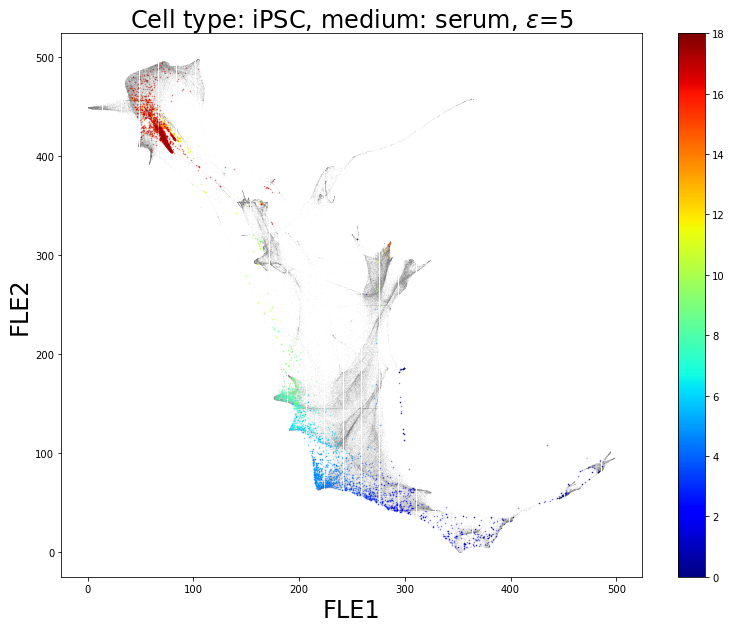

In [7]:
# Sets a matplotlib colormap
cm = plt.get_cmap("jet")
cNorm = mpl.colors.Normalize(vmin=0, vmax=len(DAYS))
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cm)

fig = plt.figure(figsize=(13, 10))
plt.title(rf"Cell type: iPSC, medium: serum, $\epsilon$={epsilon}", fontsize=24)
plt.plot(
    COORD_DF["x"],
    COORD_DF["y"],
    marker=".",
    color="gray",
    ls="",
    markersize=0.3,
    alpha=0.07,
)
for i, day in enumerate(DAYS):
    colorVal = scalarMap.to_rgba(i)
    for b in alpha_bins:
        ind_alpha = np.where(binned_cell_distribution_ipsc[day] == b)[0]
        colorVal = np.array(colorVal)
        colorVal[3] = b
        plt.plot(
            coord_ancestors_ipsc[day][ind_alpha, 0],
            coord_ancestors_ipsc[day][ind_alpha, 1],
            marker=".",
            color=colorVal,
            ls="",
            markersize=1,
        )
plt.xlabel("FLE1", fontsize=24)
plt.ylabel("FLE2", fontsize=24)
ax, _ = mpl.colorbar.make_axes(plt.gca(), shrink=1)
cbar = mpl.colorbar.ColorbarBase(
    ax, cmap=cm, norm=mpl.colors.Normalize(vmin=0, vmax=18)
)
plt.show()